In [1]:
%load_ext autoreload
%autoreload 2

In [98]:
from qiskit import execute, Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator, UnitarySimulator
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import random
import ipywidgets as widgets
import threading
import time

In [8]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = [7.00, 3.5]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 0.05
u, v = np.mgrid[0:2 * np.pi:16j, 0:np.pi:16j]
print(u.shape)
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
print(x[0], y[1], z[0])
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)
plt.show()

In [ ]:
# plt.rcParams["figure.figsize"] = [7.00, 3.5]
# plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# r = 0.05
# u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
# x = np.cos(u) * np.sin(v)
# y = np.sin(u) * np.sin(v)
# z = np.cos(v)
u, v = np.mgrid[0:2 * np.pi:16j, 0:np.pi:16j]
# x = np.linspace(0, 1)
# y = np.linspace(0, 1)
z = u * 0
# print(len(x), len(y), len(z))
# ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)
ax.plot_surface(u, v, z, cmap=plt.cm.YlGnBu_r)
plt.show()

In [114]:
class Game:    
    def __init__(self):
        self.backend = StatevectorSimulator()
        self.state = QuantumCircuit(1)
        self.gates = []
        self.points = []
        self.n_theta = 16 # number of values for theta
        self.n_phi = 16  # number of values for phi
        self.fib_sphere = np.array(Game._fibonacci_sphere(self.n_theta * self.n_phi))
#         print(self.fib_sphere)
#         self.fib_sphere = np.array(Game._fibonacci_sphere())
        self.covered = np.zeros(len(self.fib_sphere))
        self.theta, self.phi = np.mgrid[0.0:1*np.pi:self.n_theta*1j, 0.0:2.0*np.pi:self.n_phi*1j]
        self.thread = None
        self.add_gate('i') # start in |0> state

    @staticmethod
    def Rz(theta):
        return np.matrix([[ np.cos(theta), -np.sin(theta), 0 ],
                          [ np.sin(theta), np.cos(theta) , 0 ],
                          [ 0           , 0            , 1 ]])

    @staticmethod
    def _fibonacci_sphere(num_points=1000):
        # from https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere

        points = []
        phi = np.pi * (3. - np.sqrt(5.))  # golden angle in radians

        for i in range(num_points):
            y = 1 - (i / float(num_points - 1)) * 2  # y goes from 1 to -1
            radius = np.sqrt(1 - y * y)  # radius at y

            theta = phi * i  # golden angle increment

            x = np.cos(theta) * radius
            z = np.sin(theta) * radius

            points.append([x, y, z])

#         points = np.array(points) @ Game.Rz(-np.pi/8).T
        
        return points

    @staticmethod
    def _statevector_to_cartesian(sv):
        # from https://en.wikipedia.org/wiki/Bloch_sphere#Plotting_pure_two-spinor_states_through_stereographic_projection
        u = complex(0)
        if np.abs(sv[0]) > 0:
            u = sv[1] / sv[0]
            ux = u.real
            uy = u.imag
            x = 2 * ux / (1 + ux**2 + uy**2)
            y = 2 * uy / (1 + ux**2 + uy**2)
            z = (1 - ux**2 - uy**2) / (1 + ux**2 + uy**2)
        else:
            x = 0
            y = 0
            z = -1
        return np.array([x, y, z])
    
    @staticmethod
    def _get_magic_state_result():
        bs = random.getrandbits(5)
        result = ''.join('{:05b}'.format(bs))
        return result
    
    def next_round(self):
        self.gates = []
        for _ in range(5):
            bs = Game._get_magic_state_result()
            if bs.endswith('0000'):
                self.gates.append('t')
            else:
                cliffords = ['h', 'x', 'y', 'z', 's', 'sdg']
                self.gates.append(cliffords[random.randrange(len(cliffords))])        
    
    def add_gate(self, gate):
        op = getattr(self.state, gate)
        op(0)
        results = self.backend.run(self.state).result()
        psi = results.get_statevector()
        point = Game._statevector_to_cartesian(psi)
        self.points.append(point)
        
        # update what areas are covered
#         print(psi)
#         print(point)
        diff = np.array(self.fib_sphere) - point
        index = np.argmin(np.linalg.norm(diff, axis=1))
        self.covered[index] = 1
#         print(self.covered)
          
#         r = 1
#         for j in self.phi[0,:]:
#             for i in self.theta[:,0]:
#                 _x = r*np.sin(i)*np.cos(j)
#                 _y = r*np.sin(i)*np.sin(j)
#                 _z = r*np.cos(i)
#                 diff = points - (_x, _y, _z)
#                 points[np.argmin(np.linalg.norm(diff, axis=1))]
#         #         # print(diff)
#         #         print(points[np.argmin(np.linalg.norm(diff, axis=1))])
#                 val = np.linalg.norm(np.array((_x, _y, _z)) - np.array((1, 0, 0))) > 0.01
#                 inp.append([j, i, val])

    def draw(self):
        # from https://stackoverflow.com/questions/41105754/heat-map-half-sphere-plot
        r = 1        #radius of sphere

        theta, phi = np.mgrid[0.0:1*np.pi:self.n_theta*1j, 0.0:2.0*np.pi:self.n_phi*1j]

        x = r*np.sin(theta)*np.cos(phi)
        y = r*np.sin(theta)*np.sin(phi)
        z = r*np.cos(theta)

        # mimic the input array
        # array columns phi, theta, value
        # first n_theta entries: phi=0, second n_theta entries: phi=0.0315..
#         points = np.array(fibonacci_sphere(samples=32))
        inp = []
        for j in phi[0,:]:
            for i in theta[:,0]:
                _x = r*np.sin(i)*np.cos(j)
                _y = r*np.sin(i)*np.sin(j)
                _z = r*np.cos(i)
                diff = np.array(self.fib_sphere) - (_x, _y, _z)
                index = np.argmin(np.linalg.norm(diff, axis=1))
#                 if (self.covered[index] > 0):
#                     print(index)
#                 val = np.linalg.norm(np.array((_x, _y, _z)) - np.array((1, 0, 0))) > 0.01
                val = 1 - self.covered[index] * 0.75
                inp.append([j, i, val])
        inp = np.array(inp)
#         print(inp.shape)
#         print(inp[49:60, :])

        #reshape the input array to the shape of the x,y,z arrays. 
#         print(inp.shape)
        c = inp[:,2].reshape((self.n_phi,self.n_theta)).T
#         print(z.shape)
#         print(c.shape)

#         c = np.ones((n_phi, n_theta))
#         c[0,0:n_theta] = 0.25
#         c[1,1] = 0.25
#         print(x[1,1], y[1,1], z[1,1])

        #Set colours and render
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        #use facecolors argument, provide array of same shape as z
        # cm.<cmapname>() allows to get rgba color from array.
        # array must be normalized between 0 and 1
        ax.plot_surface(
            x,y,z,  rstride=1, cstride=1, facecolors=cm.hot(c/c.max()), alpha=0.6, linewidth=1) 
        ax.scatter(self.fib_sphere[:,0], self.fib_sphere[:,1], self.fib_sphere[:,2], color='r', s=0.5)
#         ax.plot_surface(
#             x,y,z,  rstride=1, cstride=1, facecolors=cm.hot(c), alpha=0.6, linewidth=1) 
        ax.view_init(25, 45)
#         for angle in range(0, 360):
#             ax.view_init(30, angle)
#             plt.draw()
#             plt.pause(.001)
        # ax.set_xlim([-2.2,2.2])
        # ax.set_ylim([-2.2,2.2])
        # ax.set_zlim([0,4.4])
        # ax.set_aspect("equal")
        #ax.plot_wireframe(x, y, z, color="k") #not needed?!
        # plt.savefig(__file__+".png")
#         plt.quiver(*np.zeros(3), *points[-1], length=1, color=['g'])
        plt.quiver(*np.zeros(3), *self.points[-1], length=1, color=['g'])
        plt.close(fig)
        return fig
#         plt.show()

    def play(self):
        buttons = []
        
        def update_buttons(buttons):
            for i, b in enumerate(buttons):
                b.description = self.gates[i]
                b.disabled = False
                if b.description == 't':
                    b.icon = 'check'
                else:
                    b.icon = ''
        
        class TimerThread(threading.Thread):
            # from https://stackoverflow.com/questions/323972/is-there-any-way-to-kill-a-thread
            """Thread class with a stop() method. The thread itself has to check
            regularly for the stopped() condition."""

            def __init__(self, game=None, *args, **kwargs):
                super(TimerThread, self).__init__(target=self.update_timer, *args, **kwargs)
                self._stop_event = threading.Event()
                self.game = game

            def stop(self):
                self._stop_event.set()

            def stopped(self):
                return self._stop_event.is_set()            

            def update_timer(self, timer, countdown):
                max_time = 5 #60 * 4
                time_left = max_time
                round_time = 10
                delta = 0.2
                total = int(round_time/delta)
                while True:
                    for i in range(total):
                        if self.stopped():
                            return
                        time.sleep(delta)
                        timer.value = (total - float(i+1))/total
                        time_left -= delta
                        if time_left < 0:
                            countdown.value = f"Game Over! Final score: {np.sum(self.game.covered)}"
                            timer.value = 0
                            for b in buttons:
                                b.description = "😎"
                                b.disabled = True
                            return
                        mins = int(time_left / 60)
                        secs = int(time_left) % 60
                        countdown.value = 'Game time left: {minute:02}:{second:02}'.format(minute=mins,second=secs)
                    self.game.next_round()
                    update_buttons(buttons)                    
        
        def change_icon(btn):
            self.add_gate(btn.description)
            btn.description = '?'
            btn.disabled = True
            status = [b.disabled for b in buttons]
            if all(status):
                self.next_round()
                update_buttons(buttons)
            bloch_sphere.update()

        # start the game
        self.next_round()
            
        for g in game.gates:
            button = widgets.Button(
                description=g,
                disabled=False,
        #         button_style='', # 'success', 'info', 'warning', 'danger' or ''
        #         icon='check' # (FontAwesome names without the `fa-` prefix)
            )
            button.on_click(change_icon)
            buttons.append(button)
            
        timer = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
        countdown = widgets.Label(value="")
            
        if self.thread is not None:
            self.thread.stop()
            self.thread.join()
        self.thread = TimerThread(game=self, args=(timer,countdown))
        self.thread.start()
    
        bloch_sphere = widgets.interactive(lambda: display(game.draw()))
        return widgets.VBox([countdown, timer, widgets.HBox(buttons), bloch_sphere])

In [115]:
game = Game()
game.play()

[0.70710678+0.j 0.70710678+0.j]


┌───┐┌───┐
q_0: ┤ I ├┤ H ├
     └───┘└───┘

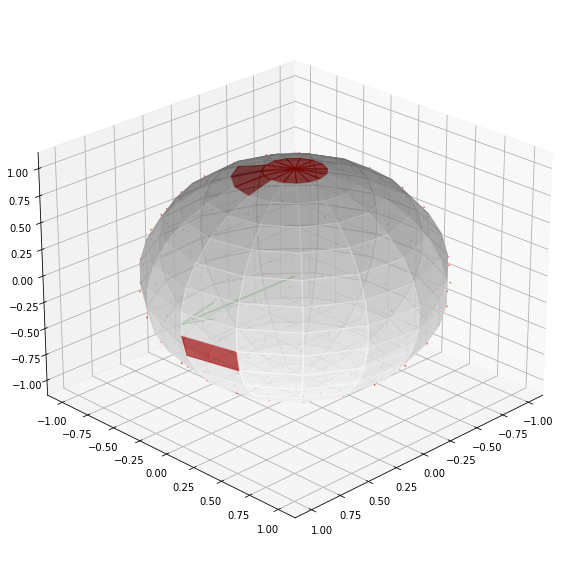

In [69]:
# game.add_gate('h')
# display(game.state.draw())
# display(game.draw())
# # print(game.points)

exiting
thread started


In [57]:
game.points

[array([0., 0., 1.]), array([0., 0., 1.])]